# Анализ данных маркетплейса

## Список необходимых задач

   * №1 Оценить месячный retention в оформление заказа с помощью когортного анализа.
   * №2 Определить, существует ли product/market fit у этого маркетплейса.
   * №3 Определить 5 основных метрик, на которых продакту можно сконцентрироваться, чтобы максимизировать прибыль компании.
   * №4 Выбрать одну из 3-х основных гипотез с помощью фреймворка ICE.
   * №5 Сформулировать нужные метрики, на которые гипотеза должна повлиять.

### Загрузка и подготовка данных

In [1]:
import pandas as pd
from operator import attrgetter
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
%matplotlib inline


In [60]:
customers   = pd.read_csv('data/olist_customers_dataset.csv')
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
orders      = pd.read_csv('data/olist_orders_dataset.csv')


### Проверка данных в customers

In [3]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [4]:
customers.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [5]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


* **customer_id** — подзаказный идентификатор пользователя

* **customer_unique_id** — уникальный идентификатор пользователя (аналог номера паспорта)

* **customer_zip_code_prefix** — почтовый индекс пользователя

* **customer_city** — город доставки пользователя

* **customer_state** — штат доставки пользователя



### Проверка данных в order_items

In [6]:
order_items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [7]:
# Изменение формата отображения даты
order_items['shipping_limit_date'] = pd.to_datetime(order_items['shipping_limit_date'])

In [8]:
order_items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [9]:
order_items.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [10]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


* **order_id** — уникальный идентификатор заказа (номер чека)

* **order_item_id** — идентификатор товара внутри одного заказа

* **product_id** — id товара (аналог штрихкода)

* **seller_id** — id производителя товара

* **shipping_limit_date** — максимальная дата доставки продавцом для передачи заказа партнеру по логистике

* **price** — цена за единицу товара

* **freight_value** — вес товара 



### Проверка данных в orders

In [11]:
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [12]:
# Изменение формата отображения даты
orders['order_purchase_timestamp']      = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at']             = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date']  = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

In [13]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [14]:
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [15]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


* **order_id** — уникальный идентификатор заказа (номер чека)

* **customer_id** — позаказный идентификатор пользователя

* **order_status** — статус заказа

* **order_purchase_timestamp** — время создания заказа

* **order_approved_at** — время подтверждения оплаты заказа

* **order_delivered_carrier_date** — время передачи заказа в логистическую службу

* **order_delivered_customer_date** — время доставки заказа

* **order_estimated_delivery_date** — обещанная дата доставки

## Задача №1
**Оценить месячный retention в оформление заказа с помощью когортного анализа**

In [16]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13


**Для проведения когортного анализа мне нужно джойнить таблицы orders и customers для получения уникального id клиента и номера заказа для каждого клиента**

In [17]:
merge_orders_customers = pd.merge(orders, customers, on='customer_id', how='inner')
merge_orders_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


Т.к. необходимо оценить месячный retention в оформление заказа, то я оставляю заказы со всеми статусами (включая отмененные). Необходимо оценить сколько человек в целом готовы возвращаться к оформлению заказов. Было бы интересно посмотреть логи и понять причину отмены со стороны клиентов.

In [18]:
# Извлекаю месяц заказа
merge_orders_customers['order_period'] = merge_orders_customers['order_purchase_timestamp'].dt.to_period('M')
merge_orders_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_period
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02


In [19]:
# Присваиваю когорты на основе даты первого действия для каждого клиента 
merge_orders_customers['cohort_period'] = merge_orders_customers.groupby('customer_unique_id')['order_purchase_timestamp']\
    .transform('min').dt.to_period('M')
merge_orders_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_period,cohort_period
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10,2017-09
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02,2018-02


In [20]:
# Рассчитываю номер периода
merge_orders_customers['period_number_month'] = (
    (merge_orders_customers['order_period'].dt.year - merge_orders_customers['cohort_period'].dt.year) * 12 +
    (merge_orders_customers['order_period'].dt.month - merge_orders_customers['cohort_period'].dt.month)
)
merge_orders_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_period,cohort_period,period_number_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10,2017-09,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07,2018-07,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08,2018-08,0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11,2017-11,0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02,2018-02,0


In [21]:
# Агрегирую данные по когортам и рассчитанному номеру периода (в месяцах)
df_cohort = merge_orders_customers.groupby(['cohort_period', 'period_number_month'])\
    .agg(n_customers=('customer_unique_id', 'nunique')).reset_index()
df_cohort.head()

,cohort_period,period_number_month,n_customers
0,2016-09,0,4
1,2016-10,0,321
2,2016-10,6,1
3,2016-10,9,1
4,2016-10,11,1


In [22]:
# Сводная таблица по когортному анализу
cohort_pivot = df_cohort.pivot_table(index='cohort_period', 
                                     columns='period_number_month', 
                                     values='n_customers',
                                     aggfunc='sum')
cohort_pivot

period_number_month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort_period,,,,,,,,,,,,,,,,,,,,
2016-09,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,321.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,764.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,3.0,1.0,6.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0,NaN,NaN
2017-03,2636.0,13.0,10.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,4.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN,NaN
2017-04,2352.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,5.0,NaN,NaN,NaN
2017-05,3596.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,9.0,11.0,9.0,12.0,9.0,1.0,7.0,9.0,NaN,NaN,NaN,NaN
2017-06,3139.0,15.0,11.0,13.0,8.0,12.0,12.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN,NaN


In [23]:
# Рассчитываю размеры когорт (первый столбец сводной таблицы)
cohort_size = cohort_pivot.iloc[:, 0]
# Вычисляю коэффициенты удержания, деля на размер когорты
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
retention_matrix.head()

period_number_month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort_period,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003115,NaN,NaN,0.003115,NaN,0.003115,NaN,0.003115,NaN,0.003115,NaN,0.003115,0.006231,0.006231
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.003927,0.002618,0.001309,0.003927,0.001309,0.005236,0.001309,0.001309,NaN,0.003927,0.001309,0.007853,0.003927,0.001309,0.001309,0.002618,0.003927,0.001309,NaN
2017-02,1.0,0.002283,0.002854,0.001142,0.003995,0.001142,0.002283,0.001712,0.001712,0.002283,0.001142,0.002854,0.001712,0.001712,0.001142,0.000571,0.000571,0.002283,NaN,NaN


По данным видно, что в конце 2016 года есть много пустых значений, возможно это связано с тем, что в это время еще не велась регистрация данных в полном объеме.

In [24]:
# Медианный retention 1-го месяца
median_month_1 = retention_matrix[1].dropna().median()

print(f'Медианный retention 1-го месяца - {median_month_1}')

Медианный retention 1-го месяца - 0.005005561735261402


In [25]:
# Когорта с самым высоким retention на 3-й месяц
month3 = retention_matrix[3]
max_value = month3.max()
best_cohorts = month3[month3 == max_value]
print(best_cohorts)

cohort_period
2017-06    0.004141
Freq: M, Name: 3, dtype: float64


**Для визуализации результата когортного анализа сделаю тепловую карту**

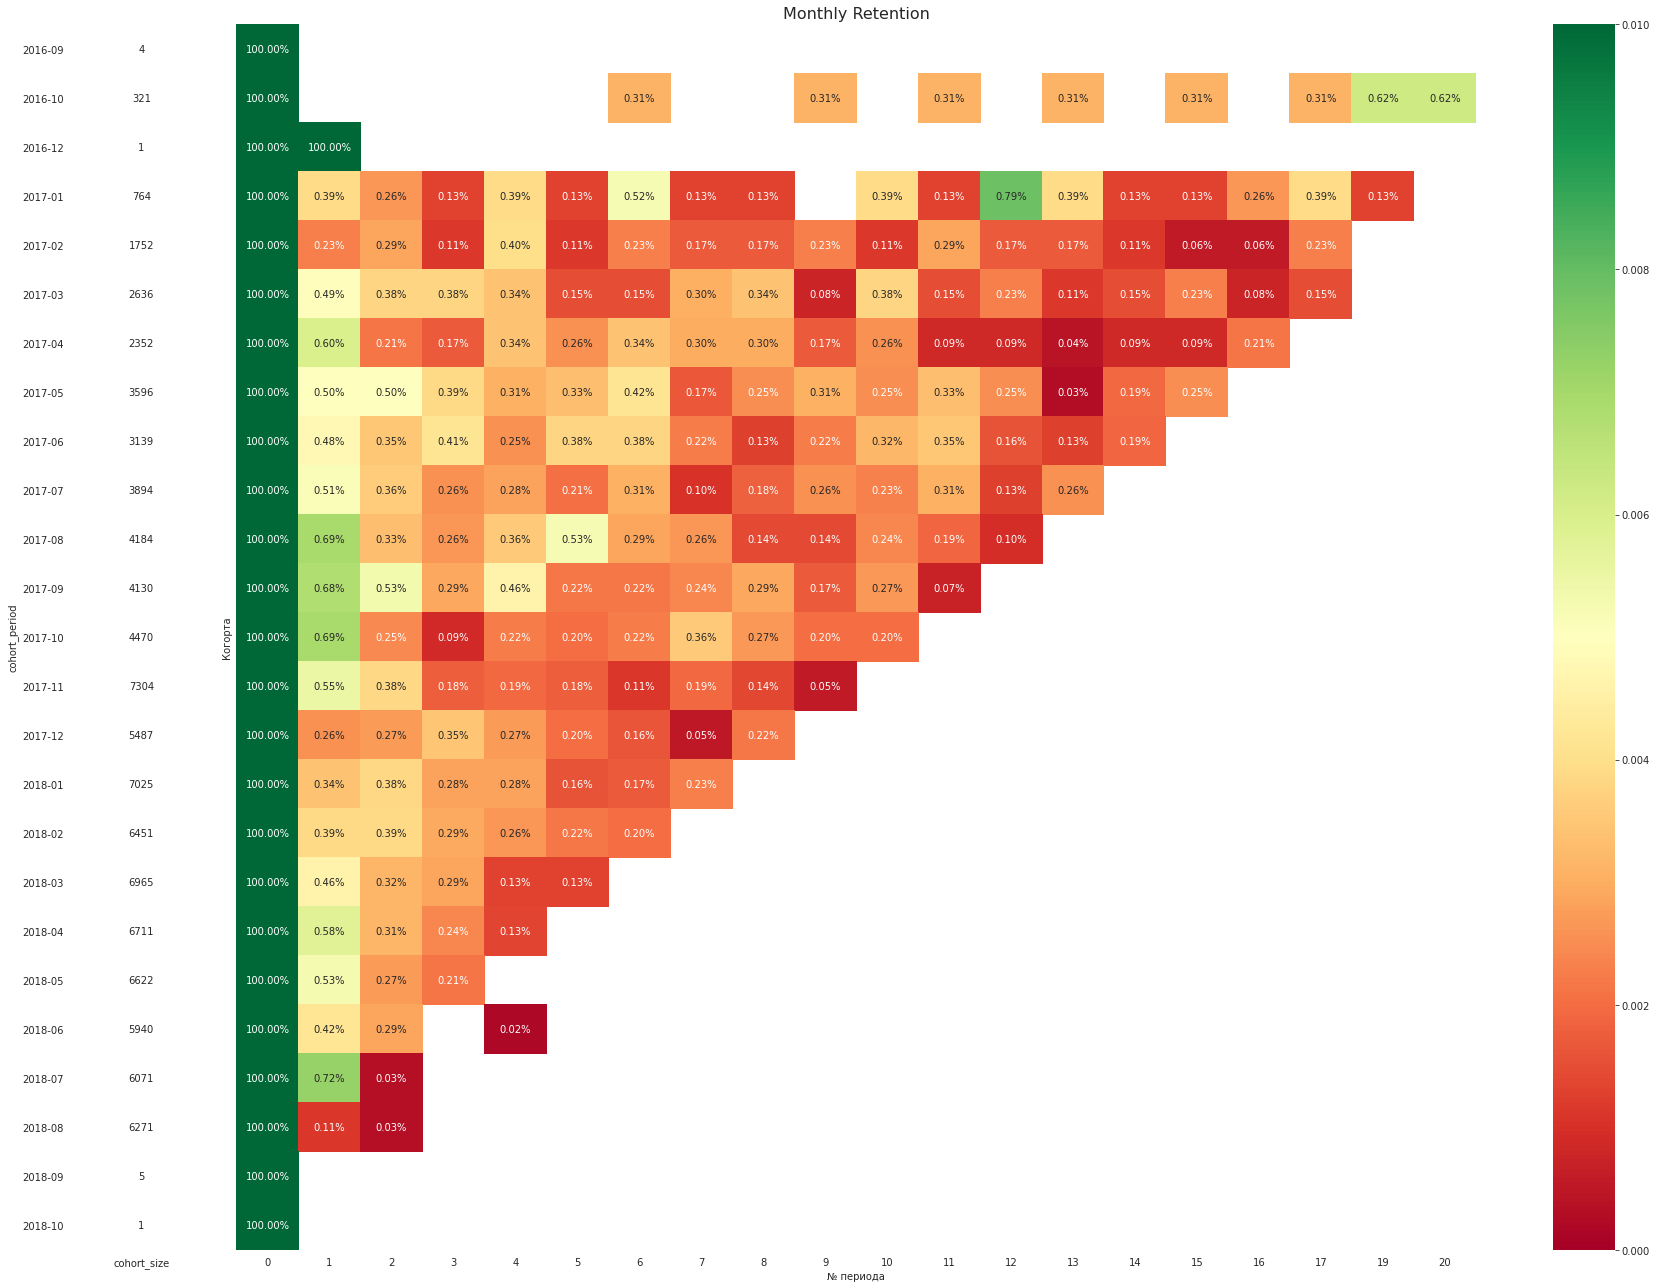

In [26]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(25, 18), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.2%',
                cmap='RdYlGn',
                vmin=0,
                vmax =0.01,
                ax=ax[1])
    ax[1].set_title('Monthly Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()

### Выводы 
**Retention** по когортам оказался очень низким. Даже с учётом всех оформленных заказов (включая отменённые), уже к третьему месяцу удержание падает почти до нуля. Это может указывать на слабую лояльность пользователей или особенности товарного предложения. 

***Медианный retention 1-го месяца - 0.5%***\
***Когорта с самым высоким retention на 3-й месяц - 2017-06 с показателем 0.4%***

## Задние № 2 
**Оценить есть ли product - market fit**

Т.к. когортный анализ показал результаты на низком уровне, я хочу посмотреть данные по клиентам чуть более детально

In [27]:
merge_orders_customers.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_period,cohort_period,period_number_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10,2017-09,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07,2018-07,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08,2018-08,0


In [28]:
# Агрегирую данные по уникальным id клиентов и считаю кол-во заказов на клиента со статусами
customer_orders = merge_orders_customers.groupby(['customer_unique_id', 'order_status'])['order_id'].nunique().reset_index()
customer_orders.columns = ['customer_unique_id','order_status', 'n_orders']
customer_orders.head()

,customer_unique_id,order_status,n_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,delivered,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,delivered,1
2,0000f46a3911fa3c0805444483337064,delivered,1
3,0000f6ccb0745a6a4b88665a16c9f078,delivered,1
4,0004aac84e0df4da2b147fca70cf8255,delivered,1


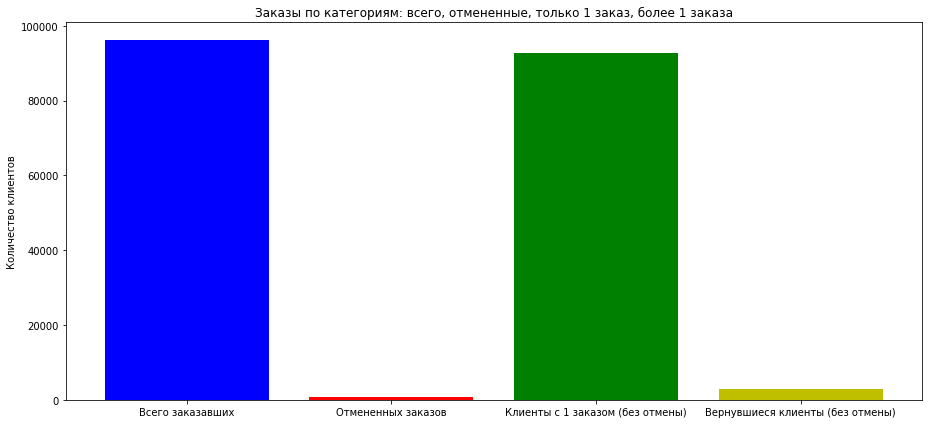

In [29]:
# Всего заказов (с отменами)
valid_orders = customer_orders.groupby('customer_unique_id')['n_orders'].sum()
# Собираю данные по отмененным заказам
canceled_orders = customer_orders.query('order_status == "canceled"')\
                                 .groupby('customer_unique_id')['n_orders'].sum()
# Клиенты, которые делали только 1 заказ (без отмены)
only_1_order = customer_orders.query('order_status != "canceled" and n_orders == 1')\
                              .groupby('customer_unique_id')['n_orders'].sum()
# Клиенты, которые делали более 1 заказа (без отмены)
repeat_customers = customer_orders.query('order_status != "canceled" and n_orders > 1')\
                                  .groupby('customer_unique_id')['n_orders'].sum()

label=['Всего заказавших', 'Отмененных заказов', 'Клиенты с 1 заказом (без отмены)', 'Вернувшиеся клиенты (без отмены)']
values=[valid_orders.shape[0], canceled_orders.shape[0], only_1_order.shape[0], repeat_customers.shape[0]]

plt.figure(figsize=(13,6))

plt.bar(label, values, color=['b','r', 'g','y'])
plt.title('Заказы по категориям: всего, отмененные, только 1 заказ, более 1 заказа')
plt.ylabel('Количество клиентов')
plt.tight_layout()
plt.show()

По графику можно увидеть, что клиенты не совершают повторную покупку, нужно проверить гипотезу о том, что проблема лежит в доставке товаров. Необходимо проверить всю цепочку осуществления доставки заказов, чтобы понять в каком из секторов были задержки

In [30]:
# Джойню все таблицы для сбора данных
c_o = pd.merge(customers, orders, on='customer_id')
all_data = pd.merge(c_o, order_items, on='order_id')


# Отсекаю только доставленные заказы 
all_delivered_orders = all_data.query('order_status != "canceled"').copy()
all_delivered_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [31]:
orders_info = all_delivered_orders[['customer_unique_id','seller_id', 'order_id']].copy()
# Задержка на этапе оплаты
orders_info['delay_payment']     = (all_delivered_orders['order_approved_at'] \
                                 - all_delivered_orders['order_purchase_timestamp'])\
                                   .dt.days
# Задержка продавца до передачи в доствку 
orders_info['delay_seller']      = (all_delivered_orders['order_delivered_carrier_date']\
                                 - all_delivered_orders['order_approved_at'])\
                                   .dt.days
# Задержка доставки по сравнению с передачей в доставку
orders_info['delay_shipping']    = (all_delivered_orders['order_delivered_customer_date']\
                                 - all_delivered_orders['order_delivered_carrier_date'])\
                                  .dt.days
# Фактическое опоздание с доставкой
orders_info['delay_vs_estimate'] = (all_delivered_orders['order_delivered_customer_date'] \
                                 - all_delivered_orders['order_estimated_delivery_date'])\
                                   .dt.days
orders_info = orders_info.dropna()
orders_info.head()

,customer_unique_id,seller_id,order_id,delay_payment,delay_seller,delay_shipping,delay_vs_estimate
0,861eff4711a542e4b93843c6dd7febb0,7c67e1448b00f6e969d365cea6b010ab,00e7ee1b050b8499577073aeb2a297a1,0.0,6.0,1.0,-11.0
1,290c77bc529b7ac935b93aa66c333dc3,b8bc237ba3788b23da09c0f1f3a3288c,29150127e6685892b6eab3eec79f59c7,0.0,2.0,13.0,-8.0
2,060e732b5b29e8181a18229c7b0b2b5e,7c67e1448b00f6e969d365cea6b010ab,b2059ed67ce144a36e2aa97d2c9e9ad2,1.0,21.0,3.0,1.0
3,259dac757896d24d7702b9acbbff3f3c,7c67e1448b00f6e969d365cea6b010ab,951670f92359f4fe4a63112aa7306eba,0.0,14.0,0.0,-13.0
4,345ecd01c38d18a9036ed96c73b8d066,4a3ca9315b744ce9f8e9374361493884,6b7d50bd145f6fc7f33cebabd7e49d0f,0.0,1.0,10.0,-6.0


In [32]:
# Общее количество клиентов
total_cust = orders_info['customer_unique_id'].nunique()

In [33]:
# Задержки с оплатой
d_payment = orders_info.groupby('customer_unique_id')['delay_payment'].mean()

payment_ontime  = (d_payment <= 0).sum() / total_cust * 100
payment_d_1day  = (d_payment == 1).sum() / total_cust * 100
payment_d_2days = (d_payment == 2).sum() / total_cust * 100
payment_d_7days = ((d_payment > 2) & (d_payment<= 7)).sum() / total_cust * 100
payment_d_more7 = (d_payment > 7).sum() / total_cust * 100

In [34]:
# Задержки продавца
d_seller = orders_info.groupby('customer_unique_id')['delay_seller'].mean()
 
seller_ontime  = (d_seller <= 0).sum() / total_cust * 100
seller_d_1day  = (d_seller == 1).sum() / total_cust * 100
seller_d_2days = (d_seller == 2).sum() / total_cust * 100
seller_d_7days = ((d_seller > 2) & (d_seller <= 7)).sum() / total_cust * 100
seller_d_more7 = (d_seller > 7).sum() / total_cust * 100

In [35]:
# Задержка доставки(от передачи в доставку)
d_sipping = orders_info.groupby('customer_unique_id')['delay_shipping'].mean()
 
shipping_ontime  = (d_sipping <= 0).sum() / total_cust * 100
shipping_d_1day  = (d_sipping == 1).sum() / total_cust * 100
shipping_d_2days = (d_sipping == 2).sum() / total_cust * 100
shipping_d_7days = ((d_sipping > 2) & (d_sipping <= 7)).sum() / total_cust * 100
shipping_d_more7 = (d_sipping > 7).sum() / total_cust * 100

In [36]:
# Фактическое опоздание с доставкой
delay_vs_estimate = orders_info.groupby('customer_unique_id')['delay_vs_estimate'].mean()

estimate_ontime  = (delay_vs_estimate <= 0).sum() / total_cust * 100
estimate_d_1day  = (delay_vs_estimate == 1).sum() / total_cust * 100
estimate_d_2days = (delay_vs_estimate == 2).sum() / total_cust * 100
estimate_d_7days = ((delay_vs_estimate > 2) & (delay_vs_estimate <= 7)).sum() / total_cust * 100
estimate_d_more7 = (delay_vs_estimate > 7).sum() / total_cust * 100

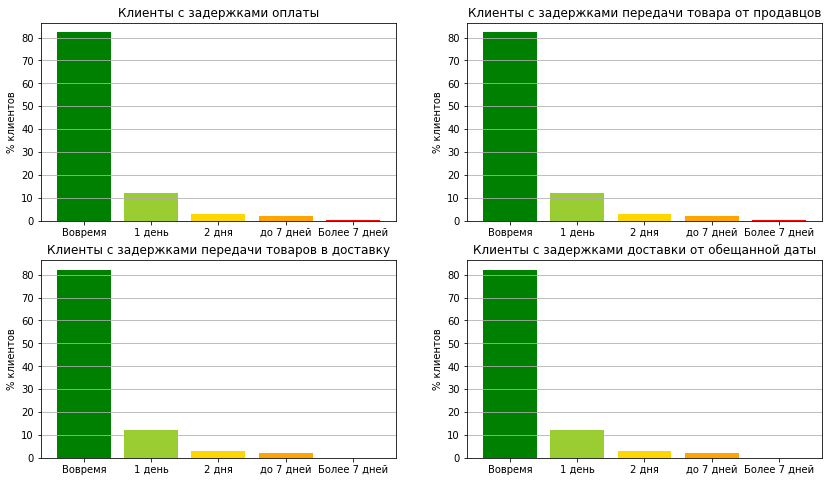

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
# График по оплатам
labels_payment = ['Вовремя', '1 день', '2 дня', 'до 7 дней', 'Более 7 дней']
values_payment = [payment_ontime, payment_d_1day, payment_d_2days, payment_d_7days, payment_d_more7]

axs[0, 0].bar(labels_payment, values_payment, color=['green', 'yellowgreen', 'gold', 'orange', 'red'])
axs[0, 0].set_title('Клиенты с задержками оплаты')
axs[0, 0].set_ylabel('% клиентов')
axs[0, 0].grid(axis='y')
# График по продавцам
labels_seller = ['Вовремя', '1 день', '2 дня', 'до 7 дней', 'Более 7 дней']
values_seller = [seller_ontime, seller_d_1day, seller_d_2days, seller_d_7days, seller_d_more7]

axs[0, 1].bar(labels_payment, values_payment, color=['green', 'yellowgreen', 'gold', 'orange', 'red'])
axs[0, 1].set_title('Клиенты с задержками передачи товара от продавцов')
axs[0, 1].set_ylabel('% клиентов')
axs[0, 1].grid(axis='y')
# График по задержкам передачи заказов
labels_shipping = ['Вовремя', '1 день', '2 дня', 'до 7 дней', 'Более 7 дней']
values_shipping = [shipping_ontime, shipping_d_1day, shipping_d_2days, shipping_d_7days, shipping_d_more7]

axs[1, 0].bar(labels_payment, values_payment, color=['green', 'yellowgreen', 'gold', 'orange', 'red'])
axs[1, 0].set_title('Клиенты с задержками передачи товаров в доставку')
axs[1, 0].set_ylabel('% клиентов')
axs[1, 0].grid(axis='y')
# График по общему опазданию
labels_estimate = ['Вовремя', '1 день', '2 дня', 'до 7 дней', 'Более 7 дней']
values_estimate = [estimate_ontime, estimate_d_1day, estimate_d_2days, estimate_d_7days, estimate_d_more7]

axs[1, 1].bar(labels_payment, values_payment, color=['green', 'yellowgreen', 'gold', 'orange', 'red'])
axs[1, 1].set_title('Клиенты с задержками доставки от обещанной даты')
axs[1, 1].set_ylabel('% клиентов')
axs[1, 1].grid(axis='y')

Посчитаю среднее время доставки от даты заказа до предположительной даты исполнения

In [38]:
delivery_time = all_data[['customer_unique_id', 'customer_id', 
                          'order_purchase_timestamp', 'order_estimated_delivery_date']].copy()
delivery_time.head()

,customer_unique_id,customer_id,order_purchase_timestamp,order_estimated_delivery_date
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,2017-06-05
1,290c77bc529b7ac935b93aa66c333dc3,18955e83d337fd6b2def6b18a428ac77,2018-01-12 20:48:24,2018-02-06
2,060e732b5b29e8181a18229c7b0b2b5e,4e7b3e00288586ebd08712fdd0374a03,2018-05-19 16:07:45,2018-06-13
3,259dac757896d24d7702b9acbbff3f3c,b2b6027bc5c5109e529d4dc6358b12c3,2018-03-13 16:06:38,2018-04-10
4,345ecd01c38d18a9036ed96c73b8d066,4f2d8ab171c80ec8364f7c12e35b23ad,2018-07-29 09:51:30,2018-08-15


In [39]:
delivery_time['month_orders'] = delivery_time['order_purchase_timestamp'].dt.to_period('M')
delivery_time['period_delivery'] = (delivery_time['order_estimated_delivery_date']\
                                 - delivery_time['order_purchase_timestamp']).dt.days
delivery_time.head()

,customer_unique_id,customer_id,order_purchase_timestamp,order_estimated_delivery_date,month_orders,period_delivery
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,2017-06-05,2017-05,19
1,290c77bc529b7ac935b93aa66c333dc3,18955e83d337fd6b2def6b18a428ac77,2018-01-12 20:48:24,2018-02-06,2018-01,24
2,060e732b5b29e8181a18229c7b0b2b5e,4e7b3e00288586ebd08712fdd0374a03,2018-05-19 16:07:45,2018-06-13,2018-05,24
3,259dac757896d24d7702b9acbbff3f3c,b2b6027bc5c5109e529d4dc6358b12c3,2018-03-13 16:06:38,2018-04-10,2018-03,27
4,345ecd01c38d18a9036ed96c73b8d066,4f2d8ab171c80ec8364f7c12e35b23ad,2018-07-29 09:51:30,2018-08-15,2018-07,16


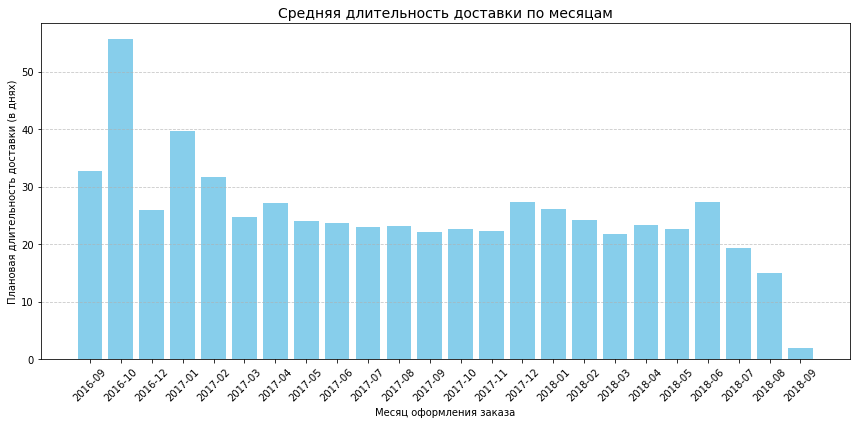

In [40]:
monthly_delivery = delivery_time.groupby('month_orders')['period_delivery'].mean().reset_index()

plt.figure(figsize=(12,6))
plt.bar(monthly_delivery['month_orders'].astype(str), monthly_delivery['period_delivery'], color='skyblue')
plt.title('Средняя длительность доставки по месяцам', fontsize=14)
plt.xlabel('Месяц оформления заказа')
plt.ylabel('Плановая длительность доставки (в днях)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### По результатам когортного анализа и анализа поведения клиентов, можно заключить, что продукт не достиг состояния PMF

**Большинство пользователей совершают только один заказ и не возвращаются в продукт, несмотря на невысокий процент отмен заказов, т.е. продукт не вызывает устойчивой потребности у аудитории. Данные по задержкам доставки товаров и распределение времени доставки положительные и не выявляют проблему, т.к. большинство заказов были исполнены вовремя, а динамика по сроку исполнения заказа показывает уменьшение времени**

Маркетплейсу стоит сосредоточиться на:
   * улучшении пользовательского опыта
   * внедрении программ удержания клиентской базы
   * анализе причин отказа от повторных покупок
   
**Цель - сформировать устойчивую базу лояльных клиентов и повысить коэффициент возвратности в продукт**

## Задание № 3
**Определить 5 основных метрик, на которых продакту можно сконцентрироваться, чтобы максимизировать прибыль компании**

In [41]:
# Буду использовать объединенные данные, собранные ранее
all_delivered_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [42]:
all_delivered_orders['month'] = all_delivered_orders['order_purchase_timestamp'].dt.to_period('M')
all_delivered_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,2018-07


**Рост объёма продаж маркетплейса**

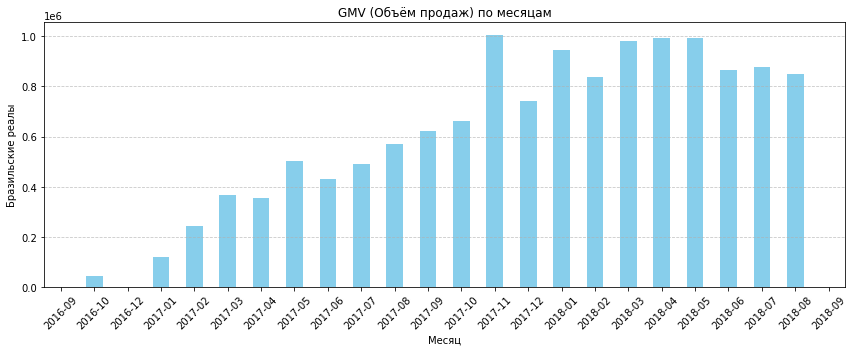

In [43]:
monthly_gmv = all_delivered_orders.groupby('month')['price'].sum()
plt.figure(figsize=(12,5))

monthly_gmv.plot(kind='bar', color='skyblue')
plt.title('GMV (Объём продаж) по месяцам')
plt.ylabel('Бразильские реалы')
plt.xlabel('Месяц')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


*Общий объем продаж в денежном выражении (исключая отменённые заказы). Показывает динамику роста и отражает масштаб бизнеса*

**Объем аудитории, которой продукт доставляет ценность (MAU)**

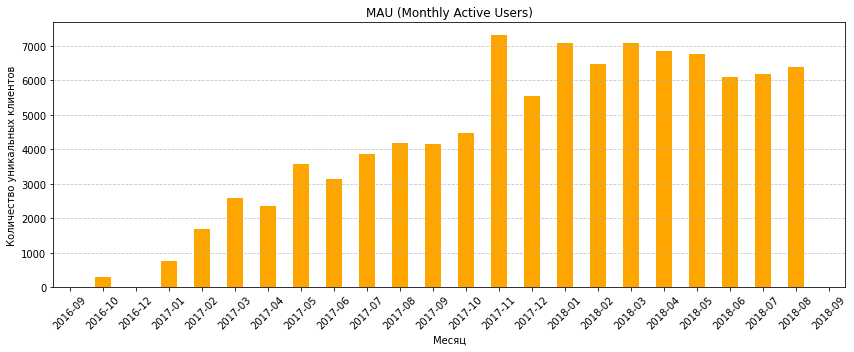

In [44]:
monthly_mau = all_delivered_orders.groupby('month')['customer_unique_id'].nunique()

monthly_mau.plot(kind='bar', figsize=(12, 5), color='orange')
plt.title('MAU (Monthly Active Users)')
plt.ylabel('Количество уникальных клиентов')
plt.xlabel('Месяц')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

*Количество уникальных пользователей, совершивших хотя бы одну покупку в месяц. Отражает охват и ценность продукта для клиентов. Рост MAU означает, что продукт привлекает больше покупателей.*

**Заинтересованность новых клиентов в продукте**

In [45]:
# Месяц первого заказа для каждого пользователя
first_orders = all_delivered_orders.groupby('customer_unique_id')['order_purchase_timestamp'].min().dt.to_period('M')
# Добавляю колонку
all_delivered_orders['first_order_month'] = all_delivered_orders['customer_unique_id'].map(first_orders)
# Кол-во новых клиентов по месяцам (т.е. клиентов, чей первый заказ пришёлся на этот месяц)
new_customers_by_month = all_delivered_orders[all_delivered_orders['month'] == all_delivered_orders['first_order_month']]\
    .groupby('month')['customer_unique_id']\
    .nunique()\
    .sort_index()\
    .reset_index()

new_customers_by_month

,month,customer_unique_id
0,2016-09,2
1,2016-10,293
2,2016-12,1
3,2017-01,752
4,2017-02,1690
5,2017-03,2571
6,2017-04,2325
7,2017-05,3541
8,2017-06,3102
9,2017-07,3822


*Количество клиентов, совершивших свой первый заказ в данном месяце. Это отражает, насколько маркетплейс привлекает новую аудиторию.*

**Вовлеченность клиента в продолжение использования продукта**

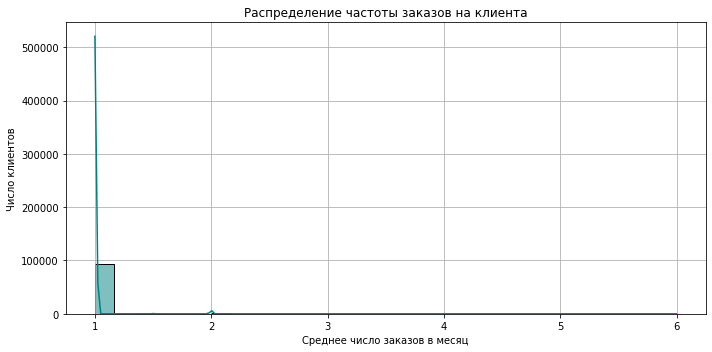

In [46]:
customer_freq = all_delivered_orders.groupby('customer_unique_id')\
                .agg({'order_id': 'nunique',
                      'month': 'nunique'})\
                .rename(columns={'order_id': 'orders_count', 'month': 'active_months'})
customer_freq['order_frequency'] = customer_freq['orders_count'] / customer_freq['active_months']

plt.figure(figsize=(10, 5))
sns.histplot(customer_freq['order_frequency'], bins=30, kde=True, color='teal')
plt.title('Распределение частоты заказов на клиента')
plt.xlabel('Среднее число заказов в месяц')
plt.ylabel('Число клиентов')
plt.grid(True)
plt.tight_layout()
plt.show()

*Среднее количество заказов на одного клиента в месяц. Показывает, насколько часто клиенты возвращаются и продолжают использовать продукт*

**Денежное выражение вовлеченности клиента**

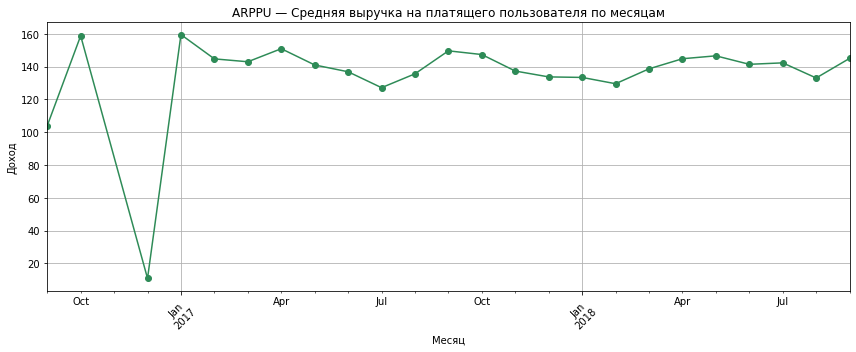

In [47]:
monthly_arppu = all_delivered_orders.groupby('month')\
                .agg({'price': 'sum',
                      'customer_unique_id': 'nunique'})\
                .rename(columns={'price': 'gmv', 'customer_unique_id': 'paying_users'})

monthly_arppu['ARPPU'] = monthly_arppu['gmv'] / monthly_arppu['paying_users']

# Визуализация
plt.figure(figsize=(12, 5))
monthly_arppu['ARPPU'].plot(marker='o', color='seagreen')
plt.title('ARPPU — Средняя выручка на платящего пользователя по месяцам')
plt.ylabel('Доход')
plt.xlabel('Месяц')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


*Средний доход с одного платящего клиента. Показывает, сколько выручки приносит вовлечённый пользователь*

**На основе анализа поведения клиентов и структуры заказов маркетплейса я выделил 5 ключевых продуктовых метрик, на которые продакт может опираться для максимизации прибыли компании. Эти метрики покрывают весь путь пользователя — от первой покупки до повторных взаимодействий и денежной вовлеченности**



## Задание № 4
**Выбрать одну из 3-х основных гипотез с помощью фреймворка ICE**

Необходимо выбрать одну из трёх основных гипотез с помощью фреймворка ICE, которые были сформированы продактом и, кажется, должны улучшить пользовательский опыт в маркетплейсе.

Для расчёта Impact возьму данные с июня 2017 года. Учитываю, что конверсия в повторный заказ равна величине медианного retention 1-го месяца - 0.5%

**Гипотезы**
   * Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен - **Confidence - 8/ Ease - 6**
   * Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов **Confidence - 10/ Ease - 4**
   * Если создадим новый способ оплаты, который будет конвертировать клиентов в повторный заказ, то клиенты не будут испытывать трудности при оформлении заказа, вследствие чего количество заказов увеличится за счёт повторных заказов тех, кто раньше не делал повторный заказ **Confidence - 5/ Ease - 9**

**Таблица расчета Impact**

|    **Impact**  |	**1** |**2**|**3**|**4**|**5**|**6**|**7**|**8**|**9**|**10**|
|:--------------:|:----:|:------:|:-------:|:-------:|:--------:|:---------:|:----:|:----:|:----:|:----:|
|Значение метрики|0 - 50|51 - 150|151 - 350|351 - 750|751 - 1550|1551 - 3150|3151 - 6350|6351 - 12750|12751 - 25550|25551 - 51 150|


**Гипотеза № 1**\
Посчитаю количество отмененных заказов с 2017-06

In [48]:
all_data.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79


In [49]:
# Беру заказы с июня 2017
orders_june2017 = all_data[all_data['order_purchase_timestamp'] >= '2017-06-01']
orders_june2017.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04,1,0be701e03657109a8a4d5168122777fb,8f2ce03f928b567e3d56181ae20ae952,2017-09-20 18:25:11,259.90,22.31


In [50]:
# Фильтрую отмененные заказы и агрегирую данные
canceled_orders_count = orders_june2017.query('order_status == "canceled"')['order_id'].nunique()
print(f"Гипотеза 1 — отменены: {canceled_orders_count} заказов")

Гипотеза 1 — отменены: 373 заказов


***По таблице Impact гипотеза 1 получает 4 балла***

**Гипотеза № 2**\
Посчитаю количество новых клиентов с июня 2017 (отмененные заказы не учитываю)

In [51]:
all_delivered_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,month,first_order_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,2017-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,2018-01,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,2018-05,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,2018-03,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,2018-07,2018-07


In [52]:
# Медианный retention 1-го месяца 
R1 = median_month_1

In [53]:
# Новые клиенты с июня 2017
new_customers = all_delivered_orders[all_delivered_orders['first_order_month'] >= '2017-06']['customer_unique_id']\
                .drop_duplicates().nunique()
new_customers

83814

In [54]:
repeat_orders = new_customers * R1
print(f"Гипотеза 2 — потенциальные повторы заказов: {repeat_orders}")

Гипотеза 2 — потенциальные повторы заказов: 419.5361512791991


***По таблице Impact гипотеза 2 получает 4 балла***

**Гипотеза № 3**\
Найду клиентов с только одним заказом в период с июня 2017

In [55]:
orders_june2017.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04,1,0be701e03657109a8a4d5168122777fb,8f2ce03f928b567e3d56181ae20ae952,2017-09-20 18:25:11,259.90,22.31


In [56]:
order_counts = orders_june2017.groupby('customer_unique_id')['order_id'].nunique()
one_order = order_counts[order_counts == 1].count()
one_order

82105

In [57]:
repeat_one_order = one_order * R1
print(f"Гипотеза 3 — «одиночки» ставшие повторными: {repeat_one_order}")

Гипотеза 3 — «одиночки» ставшие повторными: 410.98164627363735


***По таблице Impact гипотеза 3 получает 4 балла***

In [58]:
# ICE
ice_1 = 4*8*6/10
ice_2 = 4*10*4/10
ice_3 = 4*5*9/10
print(f'ICE 1 - {ice_1}\nICE 2 - {ice_2}\nICE 3 - {ice_3}')

ICE 1 - 19.2
ICE 2 - 16.0
ICE 3 - 18.0


### Таблица ICE


|  **Гипотеза**  | **Impact** | **Confidence** |  **Ease**  |   **ICE**  |
|:--------------:|:----------:|:--------------:|:----------:|:----------:|
| Гипотеза № 1   |     *4*    |       *8*      |     *6*    |  **19.2**  |
| Гипотеза № 2   |     *4*    |      *10*      |     *4*    |   **16**   |
| Гипотеза № 3   |     *4*    |       *5*      |     *9*    |   **18**   |

**По фреймфорку ICE стоит взять в работу гипотезу № 1**\
Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен.

## Задание № 5
**Сформулировать нужные метрики, на которые гипотеза должна повлиять**

На основе гипотезы, выявленной на предыдущем шаге я могу сформировать 3 метрики на которые она должна повлиять

   *****
   - **Целевая метрика**\
   ***Доля доставленных заказов от всех созданных заказов*** - прямо отражает цель гипотезы (устранение отмен заказов), если гипотеза работает - доля должна увеличиться
   *****
   - **Прокси метрика**\
   ***Среднее время от подтверждения до отгрузки заказа*** - показывает процесс перед доставкой заказа клиенту (если баг устранён, тогда заказы должны быстрее уходить в доставку)
   *****
   - **Guardrail метрика**\
   ***Среднее время доставки заказа до клиента*** - не должно ухудшаться, влияет на лояльность клиентов
   *****

# Результаты проведенного анализа

**В рамках исследования были рассмотрены следующие аспекты:**
    
   - когортный анализ по удержанию клиентов
   - исследование наличия product-market fit
   - заказы по категориям клиентов
   - временные интервалы от момента совершения заказа до доставки заказа клиенту по всей цепочке событий
   - совокупная динамика по срокам реализации доставки заказа
   
**Выделены ключевые метрики:**

   - GMV (рост объёма продаж маркетплейса)
   - MAU (объем аудитории, которой продукт доставляет ценность)
   - Количество новых клиентов (заинтересованность новых клиентов в продукте)
   - Частота заказов (вовлеченность клиентов в продолжение использования продукта)
   - ARPPU (денежное выражение вовлеченности клиентов)
   
**По фреймворку ICE выбрана гипотеза для дальнейшего изучения и выделены метрики для A/B-теста:**

   - Целевая: доля доставленных заказов от всех созданных заказов
   - Прокси: среднее время от подтверждения до отгрузки заказа
   - Guardrail: среднее время доставки заказа до клиента
   
**В качестве основных точек роста можно выделить:**

   - повышение удержание клиентов в продукте (улучшение пользовательского опыта, внедрение программ удержания клиентской базы)
   - снижение количества отмен заказов, настроить систему процессинга заказов и проверить 3 метрики (долю доставленных заказов, среднее время от подтверждения до отгрузки заказа, среднее время доставки заказа до клиента)
   - увеличить ядро лояльных и постоянных клиентов продукта
   
***Полный аналитический отчёт доступен в файле report, содержащем описания методологии и интерпретации результатов.***